<a href="https://colab.research.google.com/github/finlaycm/datascience_projects/blob/master/NYC_Evictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.image as mpimg
import json
import folium
!pip install sodapy
from sodapy import Socrata
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
import os
colab_root = "/content/" 
drive_root = '/content/drive/My Drive/Colab Notebooks'
if not os.path.isdir(drive_root):drive.mount('/content/drive/')
project_root  = os.path.join(drive_root,'NYC Evictions')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Get most recent data
client = Socrata("data.cityofnewyork.us", None)
results = client.get("6z8x-wfk4", limit=100000)
# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)
df.columns = df.columns.str.upper()

In [5]:
# Save file
filename = 'Evictions-'+pd.Timestamp('today').strftime("%m-%d-%Y")+'.csv'
df.to_csv(os.path.join(project_root,filename),index=False)

In [6]:
df['EXECUTED_DATE'] = pd.to_datetime(df.EXECUTED_DATE)
df.EVICTION_ZIP = df.EVICTION_ZIP.astype('str')
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66323 entries, 0 to 66322
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   COURT_INDEX_NUMBER          66323 non-null  object        
 1   DOCKET_NUMBER               66323 non-null  object        
 2   EVICTION_ADDRESS            66323 non-null  object        
 3   EVICTION_APT_NUM            55407 non-null  object        
 4   EXECUTED_DATE               66323 non-null  datetime64[ns]
 5   MARSHAL_FIRST_NAME          66323 non-null  object        
 6   MARSHAL_LAST_NAME           66323 non-null  object        
 7   RESIDENTIAL_COMMERCIAL_IND  66323 non-null  object        
 8   BOROUGH                     66323 non-null  object        
 9   EVICTION_ZIP                66323 non-null  object        
dtypes: datetime64[ns](1), object(9)
memory usage: 5.1+ MB
None


In [7]:
#remove Commercial
df = df[(df.EXECUTED_DATE<= pd.Timestamp('today')) & (df.RESIDENTIAL_COMMERCIAL_IND =='Residential')]
#missing 
df.EVICTION_APT_NUM.fillna('',inplace=True)
df['EVICTION_FULL_ADDRESS'] = df[['EVICTION_ADDRESS','EVICTION_APT_NUM', 'BOROUGH', 'EVICTION_ZIP']].apply\
      (lambda x:' '.join([x[i] for i in range(4)]),axis=1)
#remove duplicates 
df.drop_duplicates(inplace=True)
key_columns = ['COURT_INDEX_NUMBER','DOCKET_NUMBER','EVICTION_ADDRESS','EVICTION_APT_NUM','BOROUGH','EVICTION_ZIP']
df = df.sort_values(key_columns+['EXECUTED_DATE']).drop_duplicates(subset=key_columns, keep="last").reset_index(drop=True)
print(df.shape, df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60310 entries, 0 to 60309
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   COURT_INDEX_NUMBER          60310 non-null  object        
 1   DOCKET_NUMBER               60310 non-null  object        
 2   EVICTION_ADDRESS            60310 non-null  object        
 3   EVICTION_APT_NUM            60310 non-null  object        
 4   EXECUTED_DATE               60310 non-null  datetime64[ns]
 5   MARSHAL_FIRST_NAME          60310 non-null  object        
 6   MARSHAL_LAST_NAME           60310 non-null  object        
 7   RESIDENTIAL_COMMERCIAL_IND  60310 non-null  object        
 8   BOROUGH                     60310 non-null  object        
 9   EVICTION_ZIP                60310 non-null  object        
 10  EVICTION_FULL_ADDRESS       60310 non-null  object        
dtypes: datetime64[ns](1), object(10)
memory usage: 5.1+ MB

In [8]:
print(df.EXECUTED_DATE.min(), df.EXECUTED_DATE.max())


2017-01-03 00:00:00 2020-03-13 00:00:00


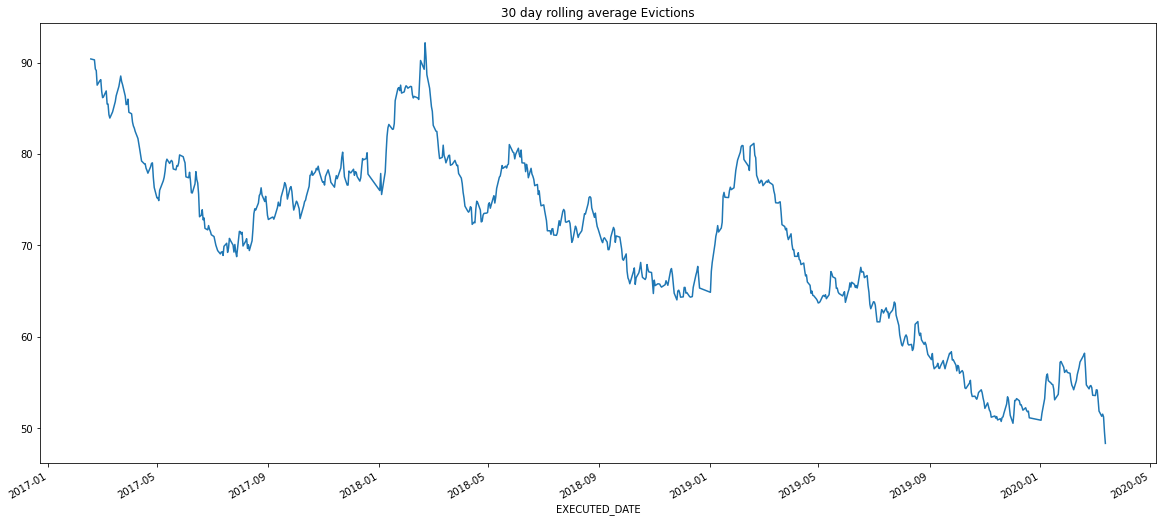

In [9]:
table = df.groupby('EXECUTED_DATE')['EVICTION_FULL_ADDRESS'].nunique()
table.fillna(0).rolling(window=30).mean().plot(x='EXECUTED_DATE', figsize=(20, 9),title='30 day rolling average Evictions')


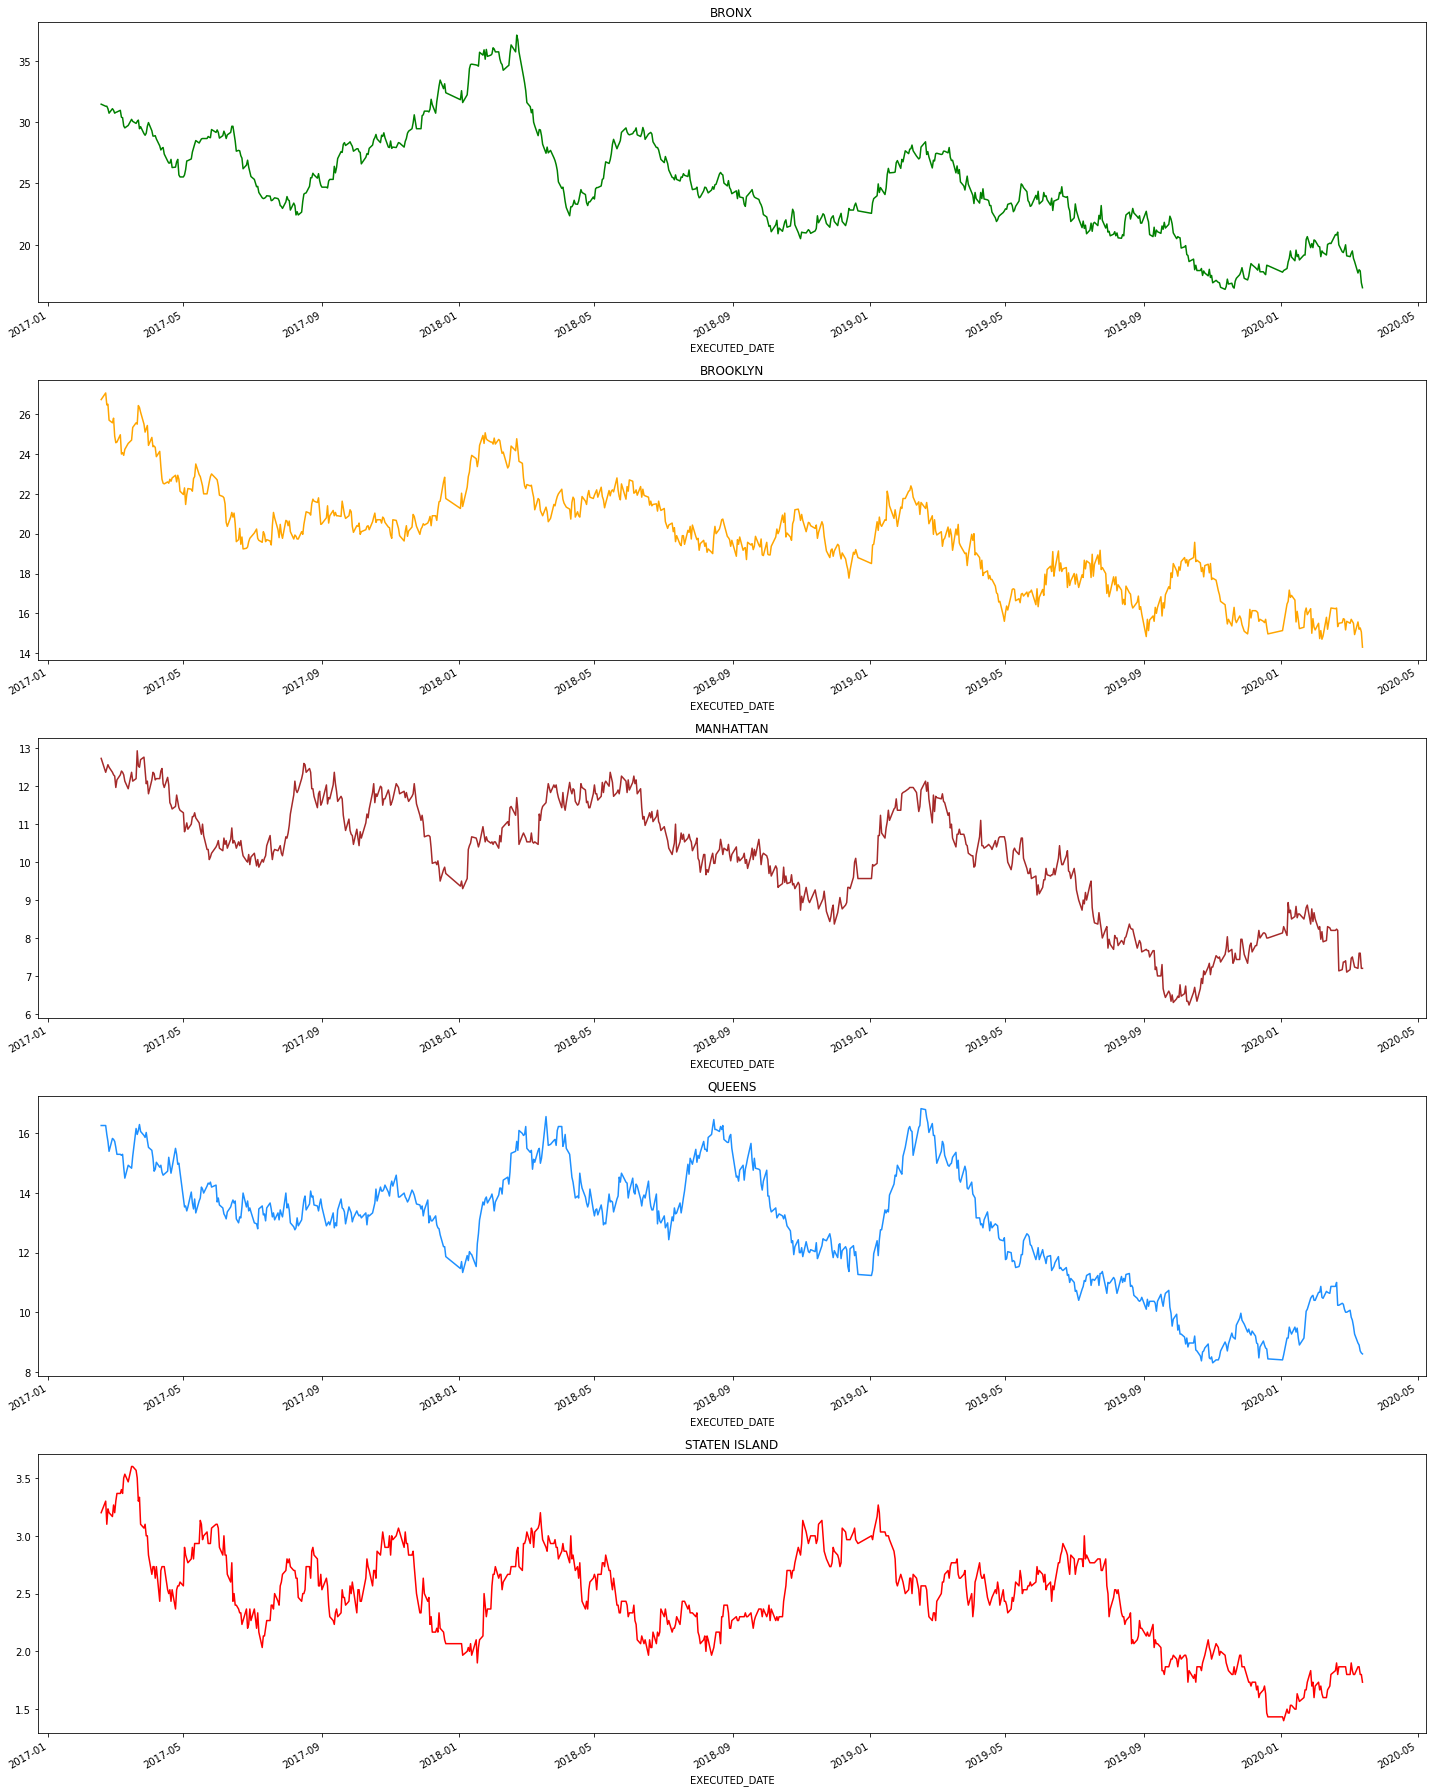

In [10]:
table = df.groupby(['EXECUTED_DATE','BOROUGH'])['EVICTION_FULL_ADDRESS'].nunique().unstack()
boroughs = table.columns
palette=['green','orange','brown','dodgerblue','red']
table_avg = table.fillna(0).rolling(window=30).mean()
fig, axes = plt.subplots(len(boroughs), figsize=(20, 5*len(boroughs)))
for i,b in enumerate(boroughs):
  table_avg[b].plot(ax=axes[i], title=b, c=palette[i])
  plt.tight_layout()


In [11]:
#census data
census_files = [os.path.join(project_root,f) for f in os.listdir(project_root) if 'DECENNIALSF12010' in f]
census_files.sort()
print(census_files)
cdf0=pd.read_csv(census_files[0], skiprows=1)
cdf1=pd.read_csv(census_files[1], skiprows=1)
cdfpop=pd.read_csv(census_files[2], skiprows=1)
cdfpop.rename(columns={'Total':'POPULATION'},inplace=True)

cdf = pd.merge(cdf0,cdf1,how='inner',on=['id','Geographic Area Name','Total',
              'Total!!Owner occupied','Total!!Renter occupied']).merge(cdfpop,on=['id','Geographic Area Name'],how='left')
cdf.columns = cdf.columns.str.replace('Total!!','').str.replace('!!',' ')
cdf['ZIP'] = cdf['Geographic Area Name'].apply(lambda x: x.split(',')[0].split()[1])
cdf.rename(columns={'Total':'UNITS'},inplace=True)
print(cdf.columns)
cdf['Renter occupied Latinx %'] = cdf[['Renter occupied','Renter occupied Hispanic or Latino householder']].apply(lambda x: x[1]/x[0],axis=1)
cdf['Renter occupied Black %'] = cdf[['Renter occupied','Renter occupied Householder who is Black or African American alone']].apply(lambda x: x[1]/x[0],axis=1)
cdf['Renter occupied Asian %'] = cdf[['Renter occupied','Renter occupied Householder who is Asian alone']].apply(lambda x: x[1]/x[0],axis=1)
cdf['Renter occupied White %'] = cdf[['Renter occupied','Renter occupied Householder who is White alone']].apply(lambda x: x[1]/x[0],axis=1)
cdf
cdf.head()

['/content/drive/My Drive/Colab Notebooks/NYC Evictions/DECENNIALSF12010.H14_data_with_overlays_2020-08-09T125557.csv', '/content/drive/My Drive/Colab Notebooks/NYC Evictions/DECENNIALSF12010.H15_data_with_overlays_2020-08-09T125557.csv', '/content/drive/My Drive/Colab Notebooks/NYC Evictions/DECENNIALSF12010.P1_data_with_overlays_2020-08-01T010947.csv']
Index(['id', 'Geographic Area Name', 'UNITS', 'Owner occupied',
       'Owner occupied Householder who is White alone',
       'Owner occupied Householder who is Black or African American alone',
       'Owner occupied Householder who is American Indian and Alaska Native alone',
       'Owner occupied Householder who is Asian alone',
       'Owner occupied Householder who is Native Hawaiian and Other Pacific Islander alone',
       'Owner occupied Householder who is Some Other Race alone',
       'Owner occupied Householder who is Two or More Races',
       'Renter occupied', 'Renter occupied Householder who is White alone',
       'Re

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in long_scalars
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars


,id,Geographic Area Name,UNITS,Owner occupied,Owner occupied Householder who is White alone,Owner occupied Householder who is Black or African American alone,Owner occupied Householder who is American Indian and Alaska Native alone,Owner occupied Householder who is Asian alone,Owner occupied Householder who is Native Hawaiian and Other Pacific Islander alone,Owner occupied Householder who is Some Other Race alone,Owner occupied Householder who is Two or More Races,Renter occupied,Renter occupied Householder who is White alone,Renter occupied Householder who is Black or African American alone,Renter occupied Householder who is American Indian and Alaska Native alone,Renter occupied Householder who is Asian alone,Renter occupied Householder who is Native Hawaiian and Other Pacific Islander alone,Renter occupied Householder who is Some Other Race alone,Renter occupied Householder who is Two or More Races,Owner occupied Not Hispanic or Latino householder,Owner occupied Hispanic or Latino householder,Renter occupied Not Hispanic or Latino householder,Renter occupied Hispanic or Latino householder,POPULATION,ZIP,Renter occupied Latinx %,Renter occupied Black %,Renter occupied Asian %,Renter occupied White %
0,8710000US3610032,"ZCTA5 10032, New York",20228,1510,540,616,5,71,0,177,101,18718,5591,4761,235,722,14,6000,1395,1086,424,7003,11715,57331,10032,0.625868,0.254354,0.038572,0.298696
1,8710000US3614774,"ZCTA5 14774, New York",46,30,30,0,0,0,0,0,0,16,16,0,0,0,0,0,0,30,0,16,0,151,14774,0.000000,0.000000,0.000000,1.000000
2,8710000US3612740,"ZCTA5 12740, New York",800,623,606,4,2,1,0,4,6,177,164,5,0,1,0,4,3,614,9,167,10,1886,12740,0.056497,0.028249,0.005650,0.926554
3,8710000US3612832,"ZCTA5 12832, New York",2750,2021,1989,7,5,5,0,1,14,729,708,4,7,0,0,2,8,2013,8,722,7,7106,12832,0.009602,0.005487,0.000000,0.971193
4,8710000US3613602,"ZCTA5 13602, New York",117,1,1,0,0,0,0,0,0,116,76,21,1,5,1,7,5,1,0,96,20,3881,13602,0.172414,0.181034,0.043103,0.655172


In [13]:
evictionsByZip = df.groupby(['EVICTION_ZIP','BOROUGH']).COURT_INDEX_NUMBER.agg('count').reset_index(name = 'EVICTIONS')
#remove zips showing up in two boroughs
evictionsByZip = evictionsByZip.sort_values(['EVICTION_ZIP','EVICTIONS']).drop_duplicates(subset='EVICTION_ZIP', keep="last").reset_index(drop=True)
evictionsByZip.rename(columns={'EVICTION_ZIP':'ZIP'},inplace=True)
# populationByZip = pd.read_csv(os.path.join(project_root,'population_zipcode.csv'))
# populationByZip.columns = ['ZIP','POPULATION']
evictionsRateByZip = pd.merge(evictionsByZip,cdf[['ZIP','POPULATION','UNITS','Renter occupied','Renter occupied Latinx %',
                                                  'Renter occupied White %', 'Renter occupied Black %', 'Renter occupied Asian %']],on='ZIP', how='inner')
# eviction rate = evictions/units%
evictionsRateByZip['EVICTION_RATE']=evictionsRateByZip['EVICTIONS']*100/evictionsRateByZip['Renter occupied']
# #[[y,z] for y,z in evictionsByZip.values if y not in list(populationByZip.ZIP.values)]
evictionsRateByZip.sort_values(by='EVICTION_RATE', inplace=True,ignore_index=True )
evictionsRateByZip = evictionsRateByZip[evictionsRateByZip.UNITS!=0]
evictionsRateByZip

,ZIP,BOROUGH,EVICTIONS,POPULATION,UNITS,Renter occupied,Renter occupied Latinx %,Renter occupied White %,Renter occupied Black %,Renter occupied Asian %,EVICTION_RATE
0,11575,QUEENS,2,16272,4055,1176,0.324830,0.147109,0.637755,0.003401,0.170068
1,11514,STATEN ISLAND,1,4673,1758,524,0.146947,0.704198,0.089695,0.120229,0.190840
2,11024,BROOKLYN,1,8002,2230,460,0.252174,0.676087,0.054348,0.080435,0.217391
3,11001,QUEENS,5,26883,9198,1860,0.141398,0.721505,0.081183,0.117204,0.268817
4,10282,MANHATTAN,7,4783,2215,2091,0.069345,0.821616,0.026781,0.113343,0.334768
...,...,...,...,...,...,...,...,...,...,...,...
177,11413,QUEENS,323,38912,12227,3828,0.058516,0.020376,0.928945,0.006792,8.437827
178,11429,QUEENS,209,25105,7290,2383,0.141838,0.078053,0.789761,0.024339,8.770457
179,11412,QUEENS,295,34882,10691,3353,0.062929,0.022666,0.913809,0.011035,8.798091
180,11411,QUEENS,94,18556,5893,1065,0.051643,0.018779,0.932394,0.002817,8.826291


In [14]:
#initialize the NYC map to show Evictions
nycMap = folium.Map(width=500,height=500, location=[40.767937,-73.982155 ],tiles='OpenStreetMap', zoom_start=10)
overlay = os.path.join(project_root,'nyc_zip_code_tabulation_areas_polygons.geojson')

nycMap.choropleth(geo_data=overlay, data=evictionsByZip, columns=['ZIP','EVICTIONS'], \
                 key_on='feature.properties.postalcode', fill_color='YlGn', fill_opacity=0.7, name = 'evitions')

folium.LayerControl().add_to(nycMap)

#initialize the NYC map to show Eviction Rate
nycMap_rate = folium.Map(width=500,height=500, location=[40.767937,-73.982155 ],tiles='OpenStreetMap', zoom_start=10)

nycMap_rate.choropleth(geo_data=overlay, data=evictionsRateByZip, columns=['ZIP','EVICTION_RATE'], \
                 key_on='feature.properties.postalcode', fill_color='YlGn', fill_opacity=0.7, name = 'evition rate')

folium.LayerControl().add_to(nycMap_rate)
display(nycMap,nycMap_rate)


/usr/local/lib/python3.6/dist-packages/folium/folium.py:426: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [15]:
palette_dic={'BRONX':'green','BROOKLYN':'orange','MANHATTAN':'brown','QUEENS':'dodgerblue','STATEN ISLAND':'red'}
evictionsRateByZip['COLOR'] = evictionsRateByZip[['BOROUGH']].apply(lambda x: palette_dic[x[0]], axis=1)

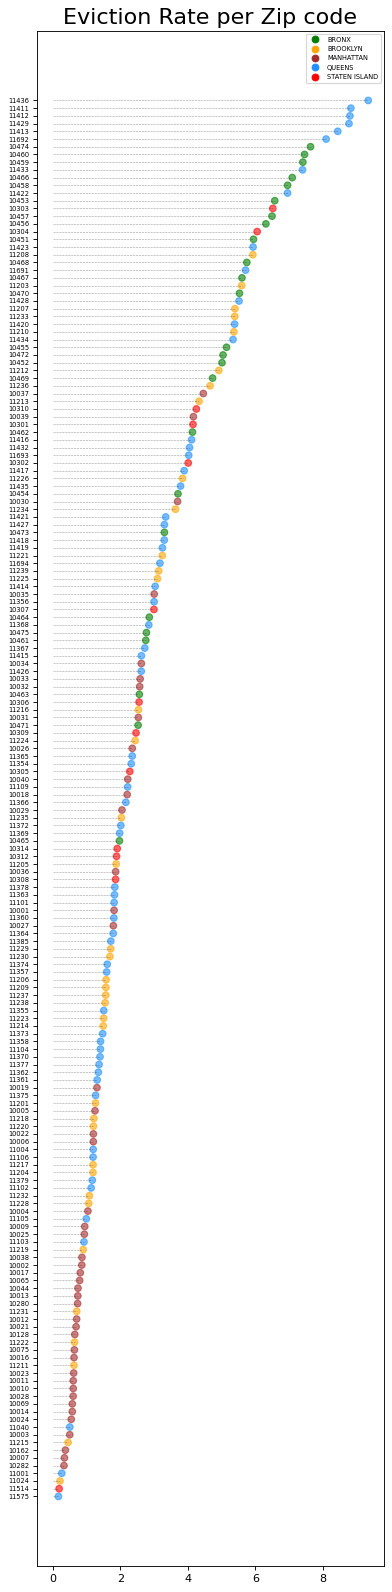

In [16]:
_ = plt.figure(figsize=(5,20), dpi= 80)
_ = plt.hlines(y=evictionsRateByZip.index, xmin=0, xmax=evictionsRateByZip.EVICTION_RATE, alpha=0.4
               , linewidth=.5,linestyle='--')
_ = plt.scatter(evictionsRateByZip.EVICTION_RATE, evictionsRateByZip.index, color=evictionsRateByZip.COLOR, alpha=0.6)
_ = plt.yticks(evictionsRateByZip.index, evictionsRateByZip.ZIP,fontsize=6)


# # Decorate
plt.title('Eviction Rate per Zip code', fontdict={'size':20})
plt.tight_layout()
from matplotlib.lines import Line2D
cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], marker='o', color='green',linestyle='None'),
                Line2D([0], [0], marker='o', color='orange',linestyle='None'),
                Line2D([0], [0], marker='o', color='brown',linestyle='None'),
                Line2D([0], [0], marker='o', color='dodgerblue',linestyle='None'),
                Line2D([0], [0], marker='o', color='red',linestyle='None')]

plt.legend(custom_lines, ['BRONX', 'BROOKLYN', 'MANHATTAN','QUEENS','STATEN ISLAND'],prop={'size': 6})
plt.show()

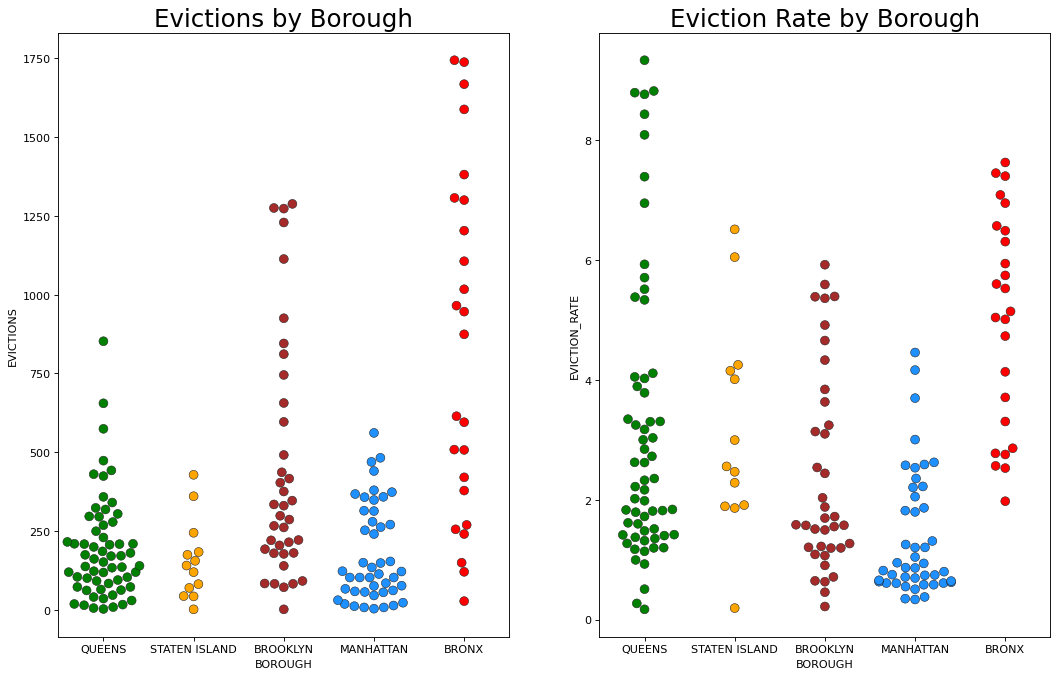

In [17]:
# Draw Stripplot
fig, ax = plt.subplots(ncols=2,figsize=(16,10), dpi= 80)  
palette=['green','orange','brown','dodgerblue','red']
sns.swarmplot(evictionsRateByZip.BOROUGH, evictionsRateByZip.EVICTIONS, size=8, ax=ax[0], linewidth=.5, palette=palette)
sns.swarmplot(evictionsRateByZip.BOROUGH, evictionsRateByZip.EVICTION_RATE, size=8, ax=ax[1], linewidth=.5, palette=palette)

# Decorations
ax[0].set_title('Evictions by Borough', fontsize=22)
ax[1].set_title('Eviction Rate by Borough', fontsize=22)
plt.show()

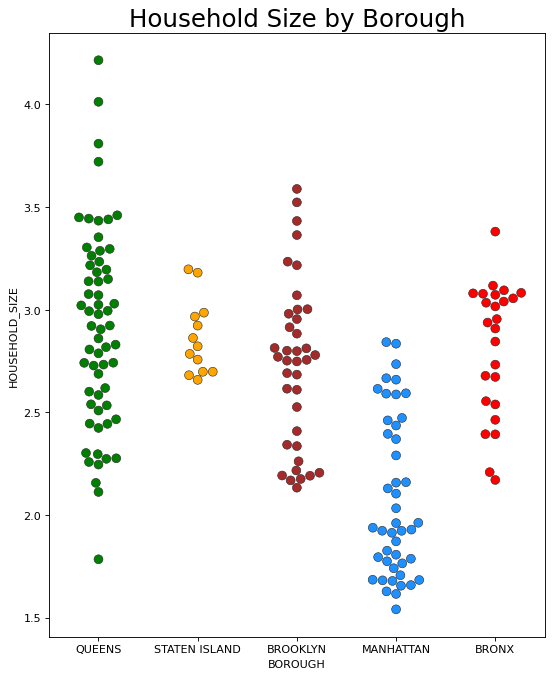

In [18]:
evictionsRateByZip['HOUSEHOLD_SIZE']=evictionsRateByZip['POPULATION']/evictionsRateByZip['UNITS']
fig, ax = plt.subplots(ncols=1,figsize=(8,10), dpi= 80)  
palette=['green','orange','brown','dodgerblue','red']
sns.swarmplot(evictionsRateByZip.BOROUGH, evictionsRateByZip.HOUSEHOLD_SIZE, size=8, ax=ax, linewidth=.5, palette=palette)

# Decorations
ax.set_title('Household Size by Borough', fontsize=22)
plt.show()

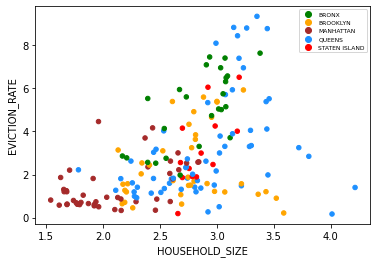

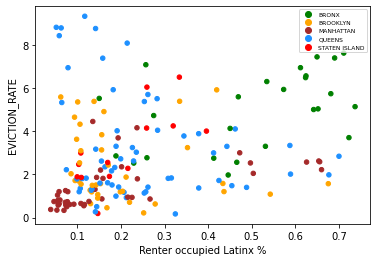

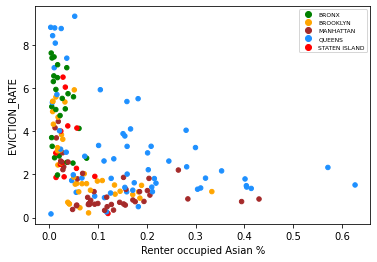

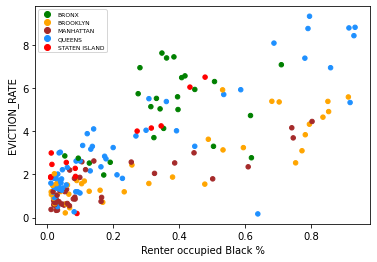

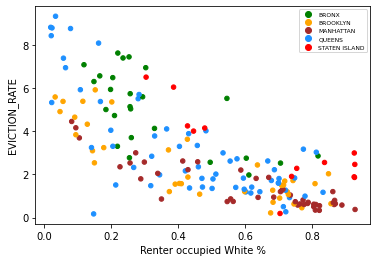

In [19]:
custom_lines = [Line2D([0], [0], marker='o', color='green',linestyle='None'),
                Line2D([0], [0], marker='o', color='orange',linestyle='None'),
                Line2D([0], [0], marker='o', color='brown',linestyle='None'),
                Line2D([0], [0], marker='o', color='dodgerblue',linestyle='None'),
                Line2D([0], [0], marker='o', color='red',linestyle='None')]

evictionsRateByZip.plot.scatter(x='HOUSEHOLD_SIZE',y='EVICTION_RATE',c='COLOR',colorbar=False)
plt.legend(custom_lines, ['BRONX', 'BROOKLYN', 'MANHATTAN','QUEENS','STATEN ISLAND'],prop={'size': 6})
evictionsRateByZip.plot.scatter(x='Renter occupied Latinx %',y='EVICTION_RATE',c='COLOR',colorbar=False)
plt.legend(custom_lines, ['BRONX', 'BROOKLYN', 'MANHATTAN','QUEENS','STATEN ISLAND'],prop={'size': 6})
evictionsRateByZip.plot.scatter(x='Renter occupied Asian %',y='EVICTION_RATE',c='COLOR',colorbar=False)
plt.legend(custom_lines, ['BRONX', 'BROOKLYN', 'MANHATTAN','QUEENS','STATEN ISLAND'],prop={'size': 6})
evictionsRateByZip.plot.scatter(x='Renter occupied Black %',y='EVICTION_RATE',c='COLOR',colorbar=False)
plt.legend(custom_lines, ['BRONX', 'BROOKLYN', 'MANHATTAN','QUEENS','STATEN ISLAND'],prop={'size': 6})
evictionsRateByZip.plot.scatter(x='Renter occupied White %',y='EVICTION_RATE',c='COLOR',colorbar=False)
plt.legend(custom_lines, ['BRONX', 'BROOKLYN', 'MANHATTAN','QUEENS','STATEN ISLAND'],prop={'size': 6})

In [84]:
gs


In [126]:
%%capture
cols = ['Renter occupied White %','Renter occupied Black %','Renter occupied Asian %','Renter occupied Latinx %']
p =   [{0:[0.09,0.09,0.4,0.4],1:[0.09,0.49,0.4,0.05,],2:[0.49,0.09,0.05,0.4,]},
       {0:[0.69, 0.09, 0.4, 0.4],1:[0.69, 0.49, 0.4, 0.05],2:[1.09, 0.09, 0.05, 0.4]},
       {0:[1.29, 0.09, 0.4, 0.4],1:[1.29, 0.49, 0.4, 0.05],2:[1.69, 0.09, 0.05, 0.4]},
       {0:[1.89, 0.09, 0.4, 0.4],1:[1.89, 0.49, 0.4, 0.05],2:[2.29, 0.09, 0.05, 0.4]}
      ]
gs = []
with sns.axes_style('white'):
  for i,c in enumerate(cols):
    gs.append(sns.jointplot(c,'EVICTION_RATE', evictionsRateByZip, kind='hex'));
    _=[a.set_position(p[i][j]) for j,a in enumerate(gs[-1].fig.axes)]
      

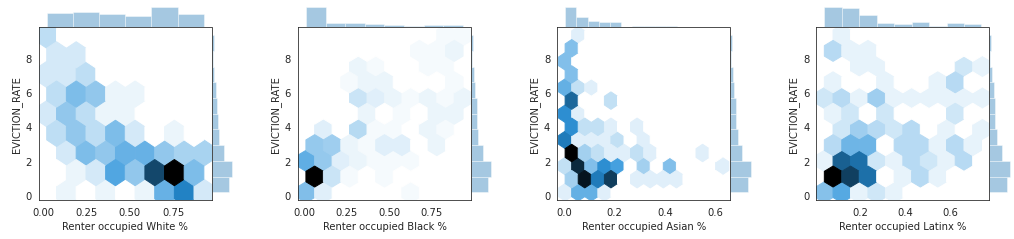

In [127]:
f = plt.figure()
for i,g in enumerate(gs):
    for j,a in enumerate(g.fig.axes):
        f._axstack.add(f._make_key(a), a)

